# Import Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
raw_df = pd.read_csv('seta_data.csv')

In [3]:
print(raw_df.shape, '\n\n', raw_df.Parameter.unique())
raw_df.head() # Long Format

(1757980, 4) 

 ['RecordID' 'Age' 'Gender' 'Height' 'ICUType' 'Weight' 'GCS' 'HR'
 'NIDiasABP' 'NIMAP' 'NISysABP' 'RespRate' 'Temp' 'Urine' 'HCT' 'BUN'
 'Creatinine' 'Glucose' 'HCO3' 'Mg' 'Platelets' 'K' 'Na' 'WBC' 'pH'
 'PaCO2' 'PaO2' 'DiasABP' 'FiO2' 'MAP' 'MechVent' 'SysABP' 'SaO2'
 'Albumin' 'ALP' 'ALT' 'AST' 'Bilirubin' 'Lactate' 'Cholesterol'
 'TroponinI' 'TroponinT']


,PATIENT_ID,Parameter,Time,Value
0,132539,RecordID,00:00,132539.0
1,132539,Age,00:00,54.0
2,132539,Gender,00:00,0.0
3,132539,Height,00:00,-1.0
4,132539,ICUType,00:00,4.0


In [4]:
static_vars = ['RecordID', 'Age', 'Gender', 
               'Height', 'ICUType']
# Extract static variables function:
def get_static(X, static_vars):
    '''Parameters:
    X: Computing in Cardiology Challenge DataFrame
    Returns: Static variables ['PATIENT_ID' 'RecordID' 'Age' 'Gender' 'Height' 
    'ICUType' 'Weight'] in wide format (i.e. PATIENT_ID is row index)'''
    
    keep_obs = np.array([True if i in static_vars else False \
                           for i in X.Parameter])
    outdf = X.loc[keep_obs & np.array(X.Time=='00:00'),
                  ['PATIENT_ID', 'Parameter', 'Value']]
    return outdf.pivot(index='PATIENT_ID', columns='Parameter', values='Value')

static_df = get_static(raw_df, static_vars=static_vars)
# Convert -1 to nan
static_df = static_df.replace(-1, np.nan).reset_index()
static_df.head()

Parameter,PATIENT_ID,Age,Gender,Height,ICUType,RecordID
0,132539,54.0,0.0,NaN,4.0,132539.0
1,132540,76.0,1.0,175.3,2.0,132540.0
2,132541,44.0,0.0,NaN,3.0,132541.0
3,132543,68.0,1.0,180.3,3.0,132543.0
4,132545,88.0,0.0,NaN,3.0,132545.0


In [25]:
# Extract time vars
time_vars = [i for i in raw_df.Parameter.unique() 
             if i not in static_vars[:-1]]

# Extract time vars function
def get_time(X, time_vars, agg_method=min):
    time_df = X.loc[np.array([True if i in time_vars else False \
                              for i in X.Parameter])]
    pivot_df = time_df.set_index(['PATIENT_ID', 'Time'], 
                                 append=True).pivot(columns='Parameter')
    groupby_df = pivot_df.groupby(['PATIENT_ID', 'Time']).agg(agg_method)
    groupby_df.columns = groupby_df.columns.get_level_values(1)
    return groupby_df.reset_index()

time_df = get_time(raw_df, time_vars)
time_df.replace(-1,np.nan,inplace=True) # convert -1 to nan

print(time_vars)
time_df.head()

['ICUType', 'Weight', 'GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'RespRate', 'Temp', 'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT']


Parameter,PATIENT_ID,Time,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,132539,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132539,00:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.1,NaN,NaN,900.0,NaN,NaN,NaN
2,132539,00:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.6,NaN,NaN,60.0,NaN,NaN,NaN
3,132539,01:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
4,132539,02:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN


# Data Exploration/Cleaning

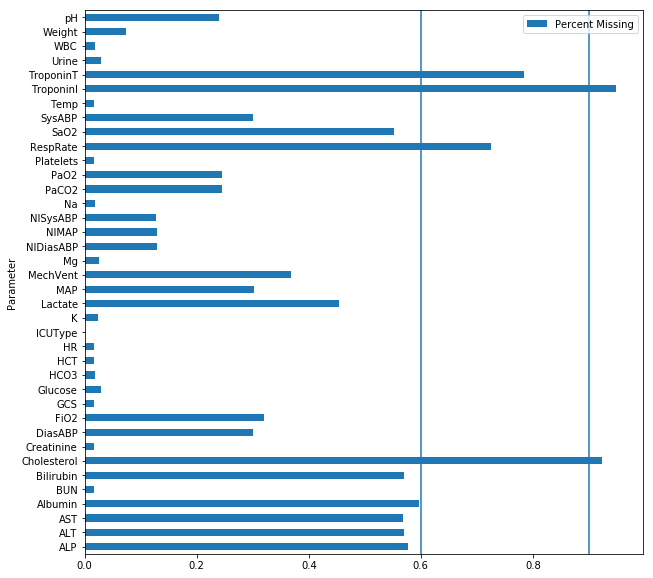

In [9]:
# What percentage of patients have 0 observations per variable?
param_miss = time_df.groupby('PATIENT_ID').mean().isna().mean().reset_index()
param_miss.columns = ['Parameter', 'Percent Missing']
param_miss.plot.barh(figsize=(10,10), x='Parameter', y='Percent Missing')
plt.axvline(x=0.9)
plt.axvline(x=0.6)
plt.show()

In [11]:
# Which variables are missing for >60% of patients?
param_miss[param_miss['Percent Missing'] > .6].Parameter

6     Cholesterol
28       RespRate
32      TroponinI
33      TroponinT
Name: Parameter, dtype: object

In [10]:
# Describe static variables
static_df.describe([.05,.1,.25,.5,.75,.9,.95,.99])

Parameter,PATIENT_ID,Age,Gender,Height,ICUType,RecordID
count,4000.000000,4000.000000,3997.000000,2106.000000,4000.000000,4000.000000
mean,137605.122000,64.247500,0.561921,169.787227,2.760000,137605.122000
std,2923.608886,17.560946,0.496213,20.174604,1.002572,2923.608886
min,132539.000000,15.000000,0.000000,1.800000,1.000000,132539.000000
5%,133038.950000,29.000000,0.000000,152.400000,1.000000,133038.950000
10%,133560.900000,40.000000,0.000000,154.900000,1.000000,133560.900000
25%,135075.750000,52.750000,0.000000,162.600000,2.000000,135075.750000
50%,137592.500000,67.000000,1.000000,170.200000,3.000000,137592.500000
75%,140100.250000,78.000000,1.000000,177.800000,4.000000,140100.250000
90%,141667.200000,85.000000,1.000000,182.900000,4.000000,141667.200000


In [15]:
# Describe time variables
print(time_df.iloc[:,:16].describe([.01,.05,.1,.25,.5,.75,.9,.95,.97,.99]),
     '\n',
     time_df.iloc[:,16:20].describe([.01,.05,.1,.25,.5,.75,.9,.95,.97,.99]),
     '\n',
     time_df.iloc[:,20:].describe([.01,.05,.1,.25,.5,.75,.9,.95,.97,.99]))

Parameter     PATIENT_ID          ALP           ALT           AST  \
count      299264.000000  3090.000000   3175.000000   3180.000000   
mean       137611.362259   116.728803    394.605984    506.525157   
std          2918.552296   133.933427   1200.529451   1516.875512   
min        132539.000000    12.000000      1.000000      4.000000   
1%         132639.000000    28.000000      6.000000     11.000000   
5%         133040.000000    39.000000     10.000000     16.000000   
10%        133551.000000    45.000000     13.000000     19.000000   
25%        135086.000000    59.000000     20.000000     31.000000   
50%        137624.000000    82.000000     43.000000     64.000000   
75%        140104.000000   122.000000    162.000000    209.000000   
90%        141655.000000   207.000000    765.600000   1005.900000   
95%        142173.000000   300.000000   2199.600000   2657.300000   
97%        142369.000000   392.660000   3409.240000   4923.060000   
99%        142572.000000   703.550

In [16]:
# MechVent has no information, plus vars with >60% missing across patients
keep_vars = ['GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Temp',
             'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3',
             'Mg', 'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2',
             'DiasABP', 'FiO2', 'MAP', 'SysABP', 'SaO2', 'Albumin',
             'ALP', 'ALT', 'AST', 'Bilirubin', 'Lactate', 'Weight']

GCS


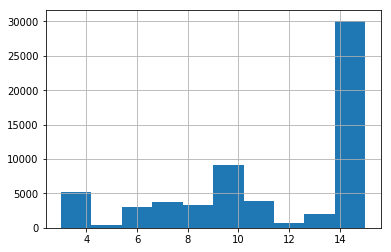




HR


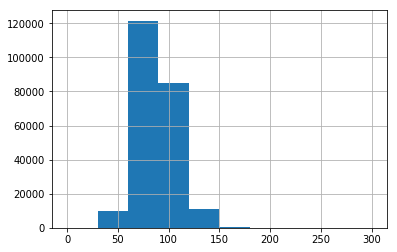




NIDiasABP


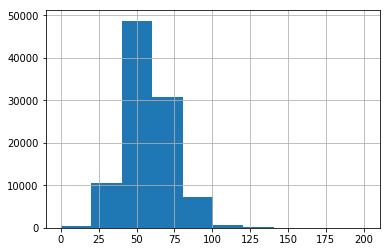




NIMAP


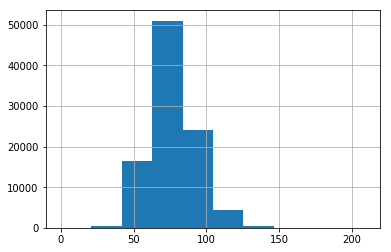




NISysABP


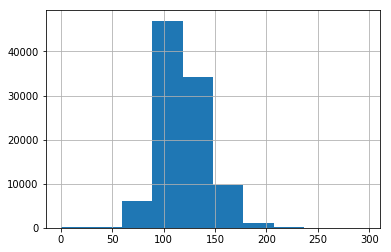




Temp


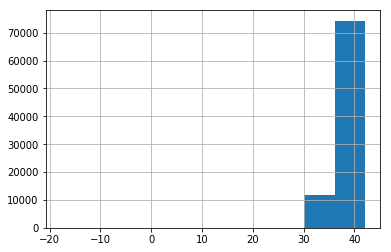




Urine


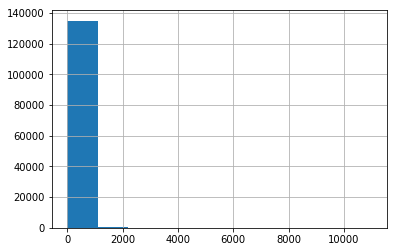




HCT


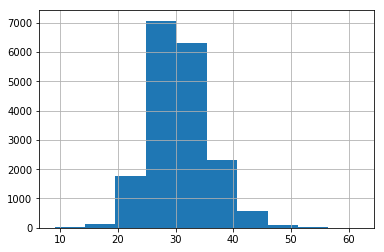




BUN


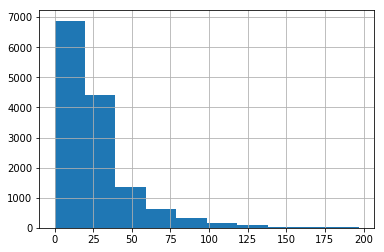




Creatinine


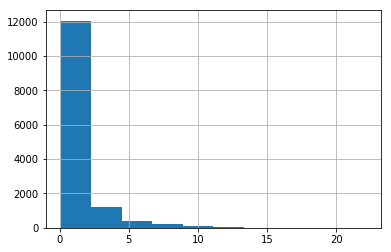




Glucose


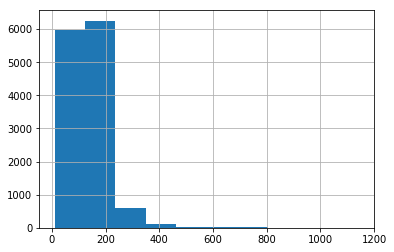




HCO3


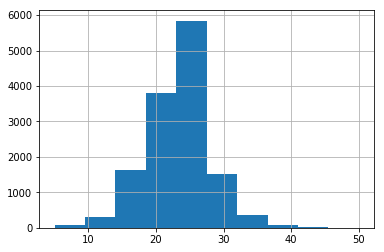




Mg


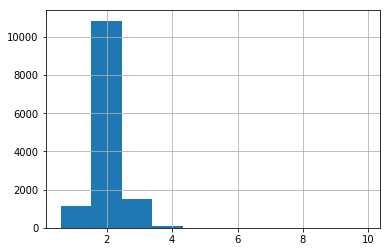




Platelets


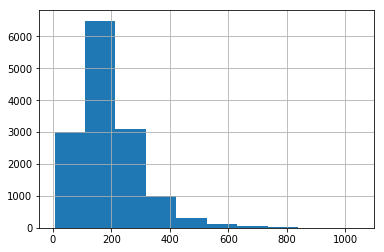




K


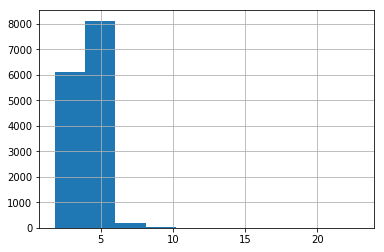




Na


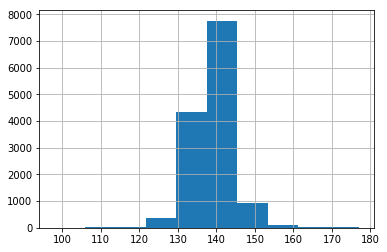




WBC


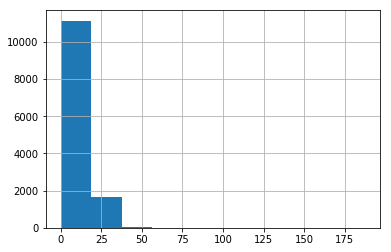




pH


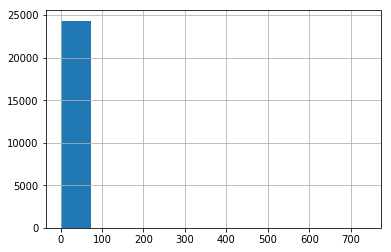




PaCO2


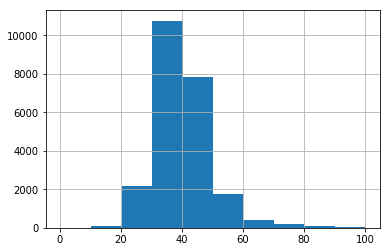




PaO2


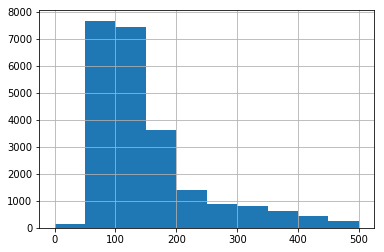




DiasABP


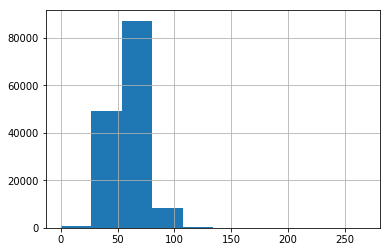




FiO2


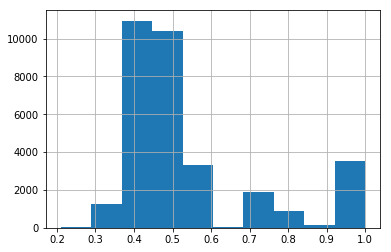




MAP


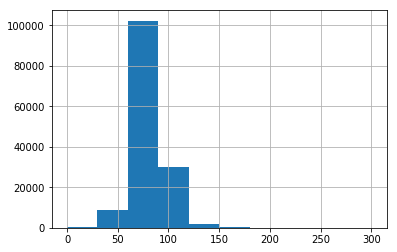




SysABP


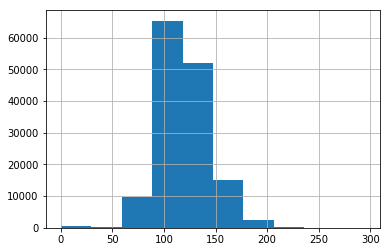




SaO2


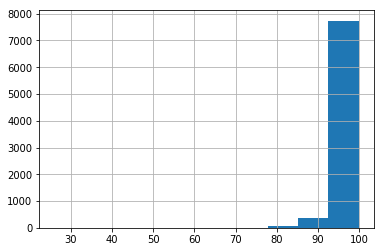




Albumin


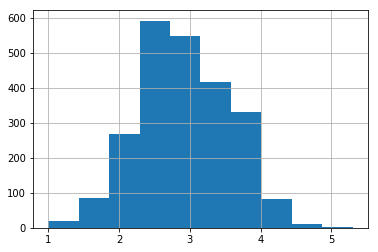




ALP


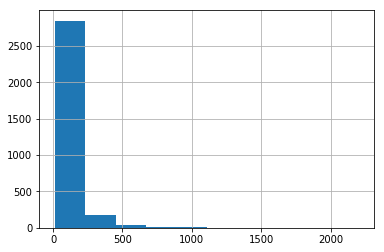




ALT


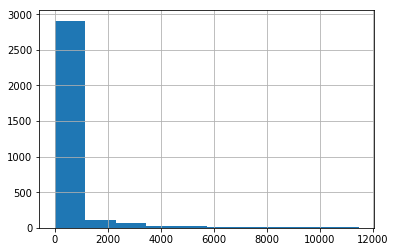




AST


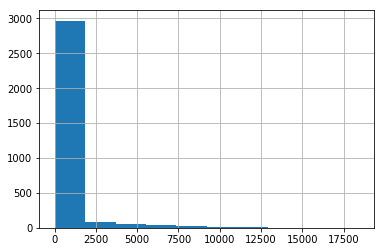




Bilirubin


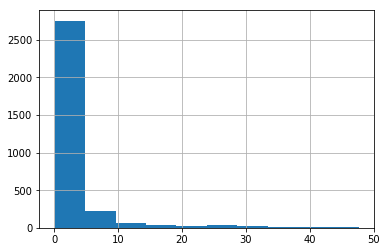




Lactate


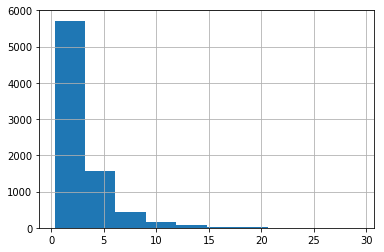




Weight


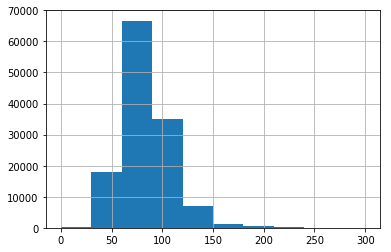

In [17]:
# Visualize keep_vars distribution
for var in keep_vars:
    print(var)
    time_df[var].hist()
    plt.show()
    print('\n\n')

GCS


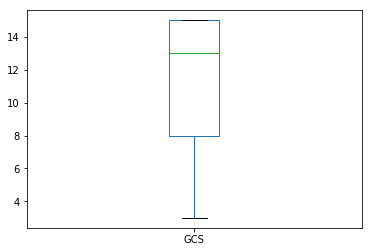

GCS
HR


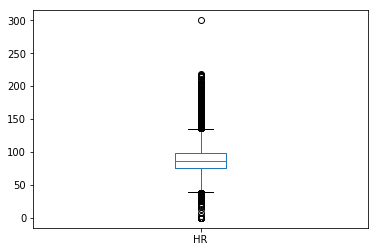

HR
NIDiasABP


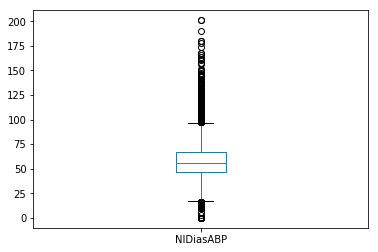

NIDiasABP
NIMAP


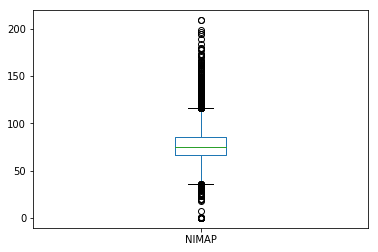

NIMAP
NISysABP


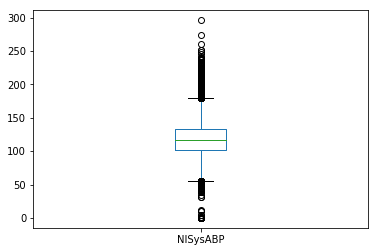

NISysABP
Temp


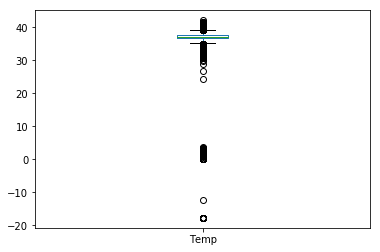

Temp
Urine


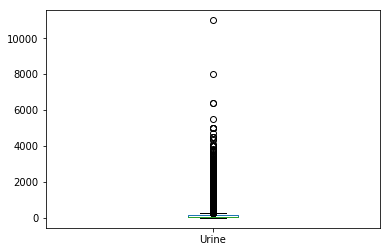

Urine
HCT


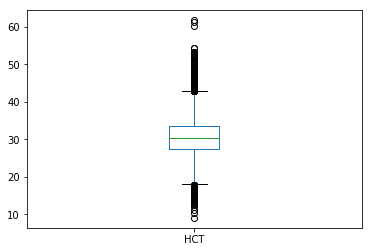

HCT
BUN


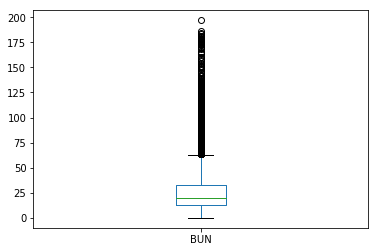

BUN
Creatinine


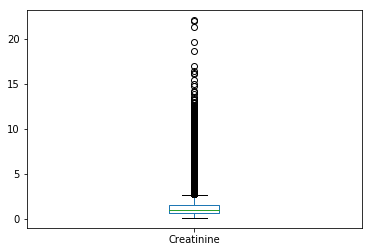

Creatinine
Glucose


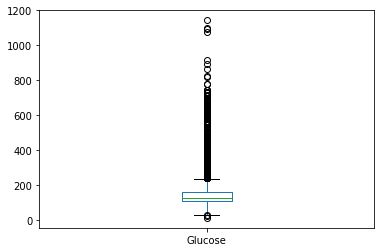

Glucose
HCO3


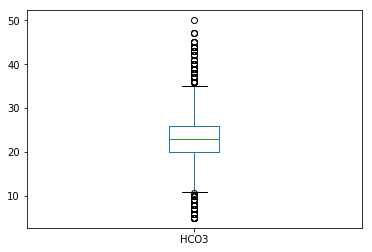

HCO3
Mg


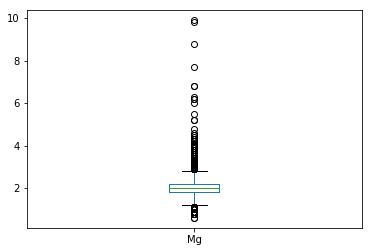

Mg
Platelets


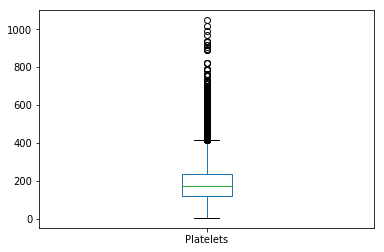

Platelets
K


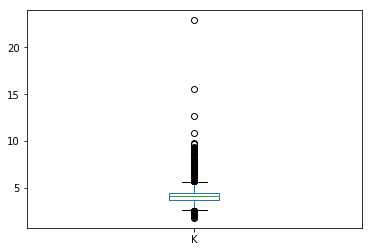

K
Na


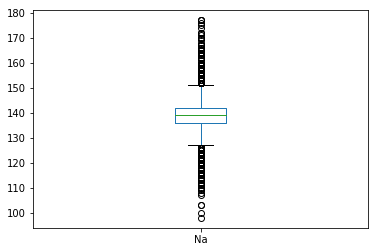

Na
WBC


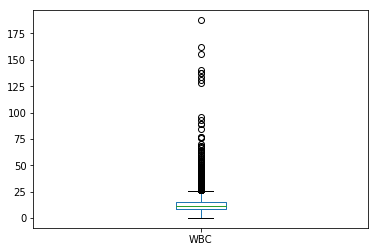

WBC
pH


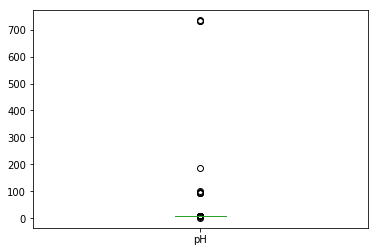

pH
PaCO2


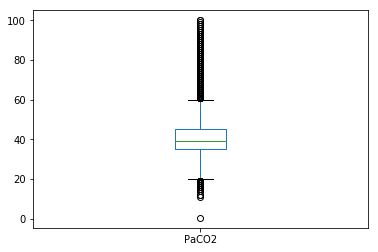

PaCO2
PaO2


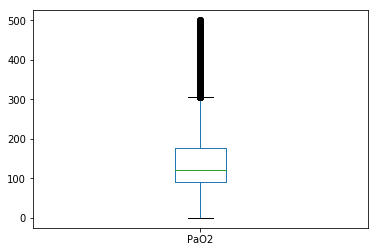

PaO2
DiasABP


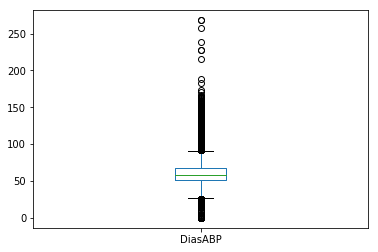

DiasABP
FiO2


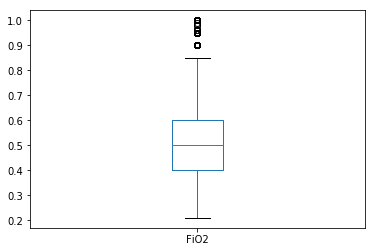

FiO2
MAP


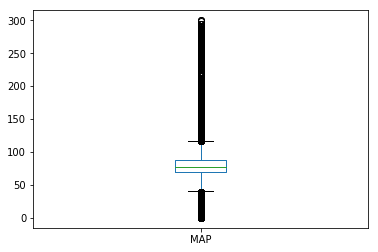

MAP
SysABP


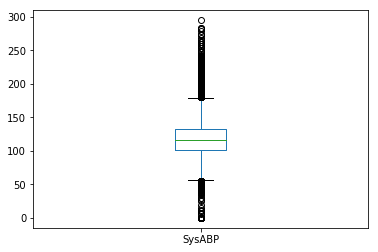

SysABP
SaO2


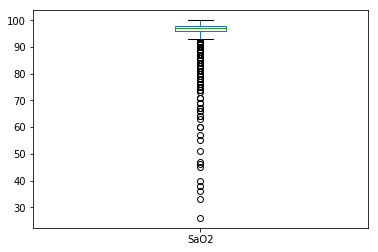

SaO2
Albumin


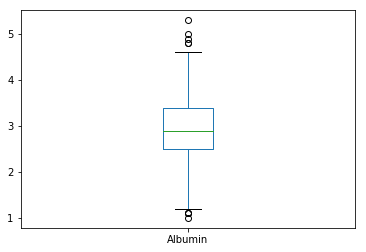

Albumin
ALP


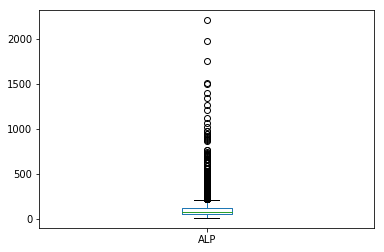

ALP
ALT


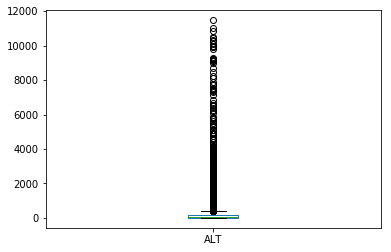

ALT
AST


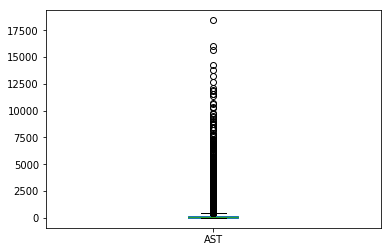

AST
Bilirubin


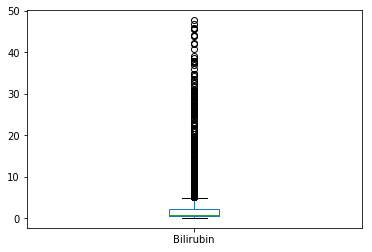

Bilirubin
Lactate


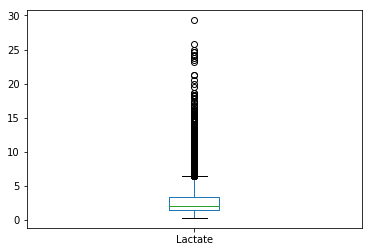

Lactate
Weight


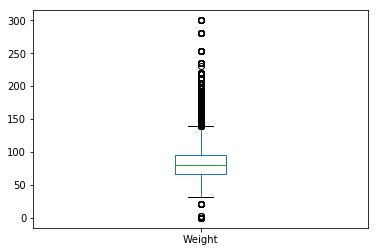

Weight


In [18]:
# Visualize keep_vars distribution, boxplots
for var in keep_vars:
    print(var)
    time_df[var].plot.box()
    plt.show()
    print(var)

In the absence of specific clinical knowledge, I'll convert all values > 99 % to nan, with the exception of pH, which I'll set from 6.8-7.8 (only liviable range).

In [19]:
time_q99 = time_df.quantile(.99)
time_q99

Parameter
PATIENT_ID     142572.0000
ALP               703.5500
ALT              7154.7200
AST              8203.8400
Albumin             4.3460
BUN               121.0000
Bilirubin          30.7110
Cholesterol       295.8800
Creatinine          8.9000
DiasABP            96.0000
FiO2                1.0000
GCS                15.0000
Glucose           390.8000
HCO3               35.0000
HCT                44.4000
HR                137.0000
ICUType             4.0000
K                   6.3000
Lactate            13.1000
MAP               128.0000
MechVent            1.0000
Mg                  3.2000
NIDiasABP          99.0000
NIMAP             119.0000
NISysABP          181.0000
Na                153.0000
PaCO2              73.0000
PaO2              450.0000
Platelets         554.0000
RespRate           36.0000
SaO2              100.0000
SysABP            185.0000
Temp               39.1000
TroponinI          43.9280
TroponinT          13.9978
Urine             675.0000
WBC               

In [30]:
# Drop variables from earlier
time_df = time_df[[i for j in 
                   [['PATIENT_ID', 'Time'], keep_vars] 
                   for i in j]].copy()

In [31]:
# Replace outliers with np.nan
for var in keep_vars:
    time_df[var] = time_df[var].where(time_df[var] < time_q99[var])

## Examine Time Resolution/Density

In [32]:
# Make time in hours variable
time_df['Hours'] = [float(i.split(':')[0]) + \
                      float(i.split(':')[1])/60 for i in time_df.Time]

My objective is to retain as much temporal resolution as possible given the sparse nature of the data. In order to do that, I need to get a sense of the proportion of patients who have observations of each variable for a given percentage of intervals for a given interval. I can then make a heatmap of those results to visualize the densitiy of information available in each variable for a given time interval. Those calculations will require some functions:

## Variable Temporal Density Functions

In [39]:
def assign_interval(l, interval, unit, return_int_len=False,
                   return_all_bins=False):
    '''Returns ceiling value of interval (closed right).
    If value==0, assigned to lowest interval
    
    l: list to get interval bin assignments for
    interval: bin width
    unit: time, 'hour', or 'minute'
    return_int_len: return total length of all bins?
    '''
    if unit=='hour':
        max_time = int(48/interval)
    elif unit=='minute':
        max_time = int(48*60/interval)
    else:
        return 'bad unit specification'
    
    int_floors = [i*interval for i in range(0,max_time)]
    int_ceilings = [i*interval for i in range(1,max_time+1)]
    
    out_l = []
    for obs in l:
        get_interval=True
        for i in range(len(int_ceilings)):
            if get_interval & (obs==0):
                out_l.append(interval)
                get_interval=False
            if get_interval & (int_floors[i] < obs <= int_ceilings[i]):
                out_l.append(int_ceilings[i])
                get_interval=False   
    if return_int_len:
        return out_l, len(int_ceilings)
    if return_all_bins:
        return out_l, int_ceilings
    else:
        return out_l
    
def bin_prop(df, var, time, interval, output='patient', p=1):
    '''Summarizes % of bins with >=1 observation at level of
    patient or % of patients with proportion p bins containing >=1 observation
    at level of variable.
    
    output='patient' returns % of bins with >=1 observation at level of patient
    output='var' returns proportion of patients with proportion >= p bins 
    containing >=1 observation.
    
    var = string of variable to summarize
    time = string of time variable to find intervals for ('Hours', 'Minutes')
    interva = bin interval (in units of l)
    p = proportion >= p, see output='var'; default 1 (all bins have >=1 value)
    '''
    if time not in ['Hours', 'Minutes']:
        return 'Bad time variable specification'

    unit = ['hour' if i is 'Hours' else 'minute' for i in [time]][0]
    bin_var, bin_len = assign_interval(df[time], interval, unit,
                                      return_int_len=True)
    gb = ['PATIENT_ID', bin_var]
    gb_df = df.groupby(gb)[var].agg(lambda x: sum(x.isna()==False)/len(x)>0)
    p_bin_patient = [sum(j)/bin_len for i, j in gb_df.groupby(level=0)]
    
    if output=='patient':
        return p_bin_patient
    if output=='var':
        return np.mean(np.array(p_bin_patient)>=p)
    else:
        return "Bad 'output' specification"
    
def get_prop_matrix(df, intervals, varlist, p):
    prop_matrix = []
    for var in varlist:
        prop_matrix.append(
            np.array(
                [bin_prop(df=df, var=var, 
                          time='Hours', interval=i, 
                          output='var', p=p) \
                 for i in intervals]
            )
        )
    return np.array(prop_matrix)

# Heatmap functions from https://matplotlib.org/3.1.0/
# gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Temporal Density Visualization

In [58]:
# Define intervals, varlist
intervals = [2, 4, 6, 8, 12, 24]
varlist = time_df.columns[2:-1].sort_values()
print(intervals, '\n', varlist)

[2, 4, 6, 8, 12, 24] 
 Index(['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Creatinine',
       'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K',
       'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2',
       'PaO2', 'Platelets', 'SaO2', 'SysABP', 'Temp', 'Urine', 'WBC', 'Weight',
       'pH'],
      dtype='object', name='Parameter')


In [36]:
import pickle
# Get prop matrices
# bin_prop is quite slow, take random sample of 500 patients
# to speed things up.
# np.random.seed(1234)
# rands = np.random.choice(time_df.PATIENT_ID.unique(),
#                         size=500,
#                         replace=False)
# rands_mask = [True if i in rands else False for i in pc_time.PATIENT_ID]
# pm_100 = get_prop_matrix(df=time_df.loc[rands_mask,:], 
#                          intervals=intervals, 
#                          varlist=varlist, 
#                          p=1)
# pm_80 = get_prop_matrix(df=time_df.loc[rands_mask,:], 
#                         intervals=intervals,
#                         varlist=varlist,
#                         p=.8)
# # Pickle pm_100/pm_80
# pickle.dump(pm_100, (open('pm_100.pickle', 'wb')))
# pickle.dump(pm_80, (open('pm_80.pickle', 'wb')))

In [52]:
pm_100.shape

(32, 6)

In [37]:
pm_100 = pickle.load(open('pm_100.pickle', 'rb'))
pm_80 = pickle.load(open('pm_80.pickle', 'rb'))

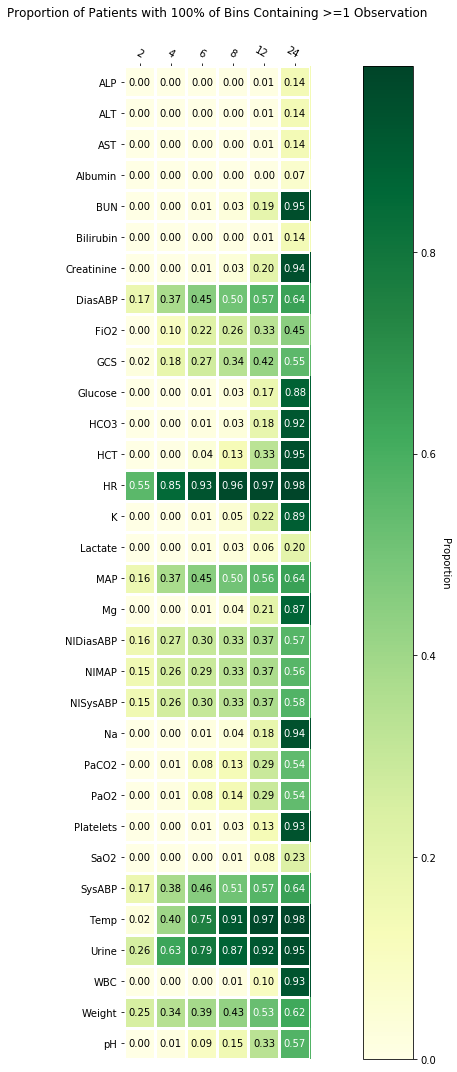

In [59]:
import matplotlib

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
im, cbar = heatmap(pm_100, varlist, intervals, ax=ax,
                   cmap="YlGn", cbarlabel="Proportion")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
plt.title('Proportion of Patients with 100%' +
          ' of Bins Containing >=1 Observation', pad=50)
fig.tight_layout()
plt.show()

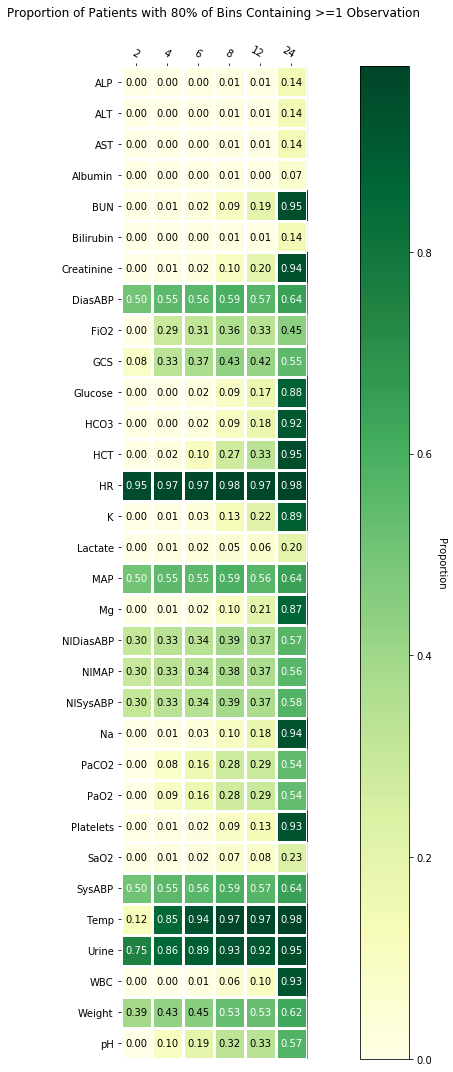

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
im, cbar = heatmap(pm_80, varlist, intervals, ax=ax,
                   cmap="YlGn", cbarlabel="Proportion")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
plt.title('Proportion of Patients with 80%' +
          ' of Bins Containing >=1 Observation', pad=50)
fig.tight_layout()
plt.show()

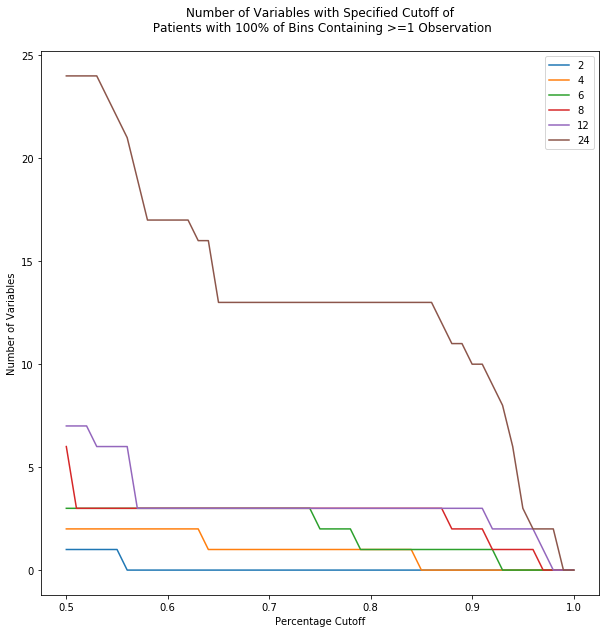

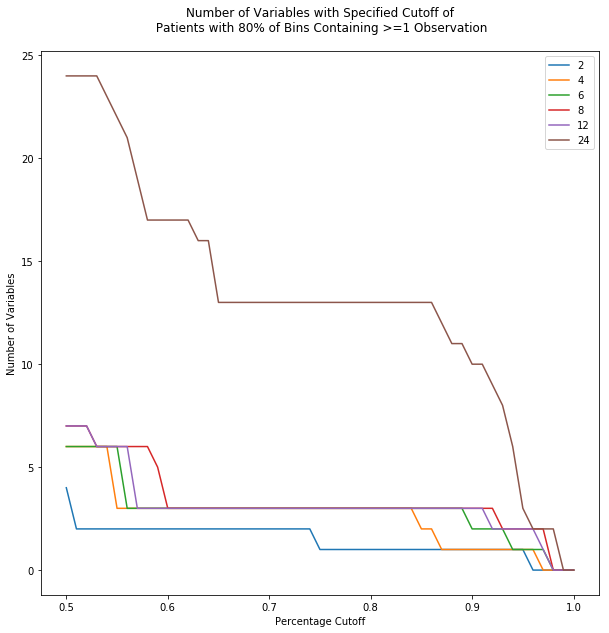

In [61]:
# Number of variables meeting percentage cutoff by interval, 100%
cutoffs = np.arange(.5,1.01,.01)
var_nums_100 = np.array([np.array(pm_100 > c).sum(axis=0) for c in cutoffs])

fig = plt.figure()
for i in range(6):
    plt.plot(cutoffs, var_nums_100[:,i])
plt.legend(intervals)
plt.xlabel('Percentage Cutoff')
plt.ylabel('Number of Variables')
plt.title('Number of Variables with Specified Cutoff of\n' +
          ' Patients with 100% of Bins Containing >=1 Observation',
         pad=20)
fig.set_size_inches(10, 10)
plt.show()

# Number of variables meeting percentage cutoff by interval, 80%
cutoffs = np.arange(.5,1.01,.01)
var_nums_80 = np.array([np.array(pm_80 > c).sum(axis=0) for c in cutoffs])

fig = plt.figure()
for i in range(6):
    plt.plot(cutoffs, var_nums_80[:,i])
plt.legend(intervals)
plt.xlabel('Percentage Cutoff')
plt.ylabel('Number of Variables')
plt.title('Number of Variables with Specified Cutoff of\n' +
          ' Patients with 80% of Bins Containing >=1 Observation',
         pad=20)
fig.set_size_inches(10, 10)
plt.show()

There are 3 variables that have >80% of patients that have 80% of full bins (below) at 4 hour increments. Those are the candidates for sequence analyses. 10 others (also below) have information in 24 hr blocks. Information for each 24 hour block will be extracted for those variables. All others will be limited to summary information for the full 48 window only.

In [62]:
seq_vars = pd.Series(varlist)[np.array(pm_80 > .8)[:,3]].to_numpy()
print('These variables have sufficient information' +
      f'in 4 hour blocks: \n{seq_vars}')

These variables have sufficient informationin 4 hour blocks: 
['HR' 'Temp' 'Urine']


In [63]:
day_vars = np.array([i for i in pd.Series(varlist)[np.array(pm_80 > .8)[:,5]] \
           if i not in seq_vars])
print(f'These variables have information in 24 hour blocks: \n{day_vars}')

These variables have information in 24 hour blocks: 
['BUN' 'Creatinine' 'Glucose' 'HCO3' 'HCT' 'K' 'Mg' 'Na' 'Platelets' 'WBC']


In [64]:
stay_vars = np.array([i for i in varlist if i not in day_vars \
                     and i not in seq_vars])
print(f'These variables are sparse, only stay summary possible: \n{stay_vars}')

These variables are sparse, only stay summary possible: 
['ALP' 'ALT' 'AST' 'Albumin' 'Bilirubin' 'DiasABP' 'FiO2' 'GCS' 'Lactate'
 'MAP' 'NIDiasABP' 'NIMAP' 'NISysABP' 'PaCO2' 'PaO2' 'SaO2' 'SysABP'
 'Weight' 'pH']


In [65]:
# % of patients with missing records (i.e. none) for stay_vars
print(time_df.groupby(['PATIENT_ID'])[stay_vars].apply(
    lambda x: x.isna().sum()==len(x)).mean(),'\n\n')
stay_dense = time_df.groupby(['PATIENT_ID'])[stay_vars].apply(
    lambda x: x.isna().sum()==len(x)).mean()<=.33
stay_sparse = time_df.groupby(['PATIENT_ID'])[stay_vars].apply(
    lambda x: x.isna().sum()==len(x)).mean()>.33
stay_dense = stay_dense.index[stay_dense] # get names
stay_sparse = stay_sparse.index[stay_sparse] # get names
print(f'Among "stay" variables, these have <=33% missing: \n{stay_dense}')
print(f'Among "stay" variables, these have >33% missing: \n{stay_sparse}')

# # PaO2/FiO2 ratio is used in hospitals and is predictive of mortality:
# # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4448284/
# # Since FaO2 is has more missing, the resulting var will be in stay_sparse
time_df['pao2_fao2_r'] = time_df['PaO2']/time_df['FiO2']
stay_sparse = list(stay_sparse)
stay_sparse.append('pao2_fao2_r')

Parameter
ALP          0.57975
ALT          0.56975
AST          0.56900
Albumin      0.60025
Bilirubin    0.57225
DiasABP      0.30050
FiO2         0.33050
GCS          0.19575
Lactate      0.45450
MAP          0.30375
NIDiasABP    0.12950
NIMAP        0.13025
NISysABP     0.12825
PaCO2        0.24675
PaO2         0.24500
SaO2         0.55425
SysABP       0.30025
Weight       0.08200
pH           0.24275
dtype: float64 


Among "stay" variables, these have <=33% missing: 
Index(['DiasABP', 'GCS', 'MAP', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2',
       'PaO2', 'SysABP', 'Weight', 'pH'],
      dtype='object', name='Parameter')
Among "stay" variables, these have >33% missing: 
Index(['ALP', 'ALT', 'AST', 'Albumin', 'Bilirubin', 'FiO2', 'Lactate', 'SaO2'], dtype='object', name='Parameter')


# Feature Engineering/Extraction/Selection

Only 3 variables have dense enough information to make proper sequences. For the rest, I'll extract some temporal information (min, max, n, etc.). Using previous research as reference, I'll gather the following variables:

Raw static variables (Age, Gender, etc.)

For stay_dense:
- min, max, median, first, last, number of points, and trend

For stay_sparse:
- recode as categorical: np.nan: 0, normal: 1, abnormal: 2; then onehot encode; normal values gathered from simple internet search

For day+seq vars: 
- (min, max, median, first, last, number of points)/day + linear trend (for whole stay)

*I'll use a median-imputation strategy for missing values*

I'll also attempt an LSTM model using HR, Temp, and Urine mean and count values in 4hr intervals.

*For sequences, I'll impute within-person means for missing values. Observations that are completely missing sequence vars will not be used in training.*

In order to aid transformations of future data, I'll do my best to do these transformations using functions and sklearn-compatible transformer classes. Those are defined below:

## Transformation Functions

In [92]:
# # Get mean_sequences for imputation
# ms_time = get_time(raw_df, seq_vars)
# ms_time['Hours'] = [float(i.split(':')[0]) + \
#                       float(i.split(':')[1])/60 for i in ms_time.Time]
# ms_collapse_df = collapse_time(ms_time, seq_vars, 4)
# mean_seq = ms_collapse_df.groupby(
#     'Time_4_hours')[['HR_mean', 'Temp_mean', 'Urine_mean']].mean()
# pickle.dump(mean_seq, open('mean_seq.pickle', 'wb'))

In [74]:
# Variable Definitions (defined earlier)
static_q99 = static_df.quantile(.99)
time_q99 = time_df.quantile(.99)
q99_dict = dict(zip(static_q99.index, static_q99))
q99_dict.update(
    dict(zip(time_q99.index, time_q99))
)
pickle.dump(q99_dict, open('q99_dict.pickle', 'wb')) # save for later

drop_vars = ['Cholesterol', 'RespRate', 
                 'TroponinI', 'TroponinT', 
                 'MechVent']
    
static_vars = ['RecordID', 'Age', 'Gender', 
               'Height', 'ICUType']
    
keep_vars = ['GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Temp',
             'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3',
             'Mg', 'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2',
             'DiasABP', 'FiO2', 'MAP', 'SysABP', 'SaO2', 'Albumin',
             'ALP', 'ALT', 'AST', 'Bilirubin', 'Lactate', 'Weight']

seq_vars = ['HR', 'Temp', 'Urine']
day_vars = ['BUN', 'Creatinine', 'Glucose', 'HCO3', 'HCT', 'K', 'Mg', 'Na',
            'Platelets', 'WBC']
stay_dense = ['DiasABP', 'GCS', 'MAP', 'NIDiasABP', 'NIMAP', 'NISysABP', 
              'PaCO2', 'PaO2', 'SysABP', 'Weight', 'pH']
stay_sparse = ['ALP', 'ALT', 'AST', 'Albumin', 'Bilirubin', 'FiO2', 
               'Lactate', 'SaO2', 'pao2_fio2_r']

stay_sparse_dict = {
    'ALP': [44, 147],
    'ALT': [7, 56],
    'AST': [10, 40],
    'Albumin': [3.4, 5.4],
    'Bilirubin': [0.1, 1.2],
    'FiO2': [-np.inf, np.inf],
    'Lactate': [-np.inf, 2],
    'SaO2': [93, 97],
    'pao2_fio2_r': [202, np.inf]
}

# Functions
def get_time(X, time_vars, agg_method=min):
    time_df = X.loc[np.array([True if i in time_vars else False \
                              for i in X.Parameter])]
    pivot_df = time_df.set_index(['PATIENT_ID', 'Time'], 
                                 append=True).pivot(columns='Parameter')
    groupby_df = pivot_df.groupby(['PATIENT_ID', 'Time']).agg(agg_method)
    groupby_df.columns = groupby_df.columns.get_level_values(1)
    return groupby_df.reset_index()

# Extract static variables:
def get_static(X, static_vars):
    '''Parameters:
    X: Computing in Cardiology Challenge DataFrame
    Returns: Static variables ['PATIENT_ID' 'RecordID' 'Age' 'Gender' 'Height' 
    'ICUType' 'Weight'] in wide format (i.e. PATIENT_ID is row index)'''
    
    keep_obs = np.array([True if i in static_vars else False \
                           for i in X.Parameter])
    outdf = X.loc[keep_obs & np.array(X.Time=='00:00'),
                  ['PATIENT_ID', 'Parameter', 'Value']]
    return outdf.pivot(index='PATIENT_ID', columns='Parameter', values='Value')

def assign_interval(l, interval, unit, return_int_len=False,
                   return_all_bins=False):
    '''Returns ceiling value of interval (closed right).
    If value==0, assigned to lowest interval
    
    l: list to get interval bin assignments for
    interval: bin width
    unit: time, 'hour', or 'minute'
    return_int_len: return total length of all bins?
    '''
    if unit=='hour':
        max_time = int(48/interval)
    elif unit=='minute':
        max_time = int(48*60/interval)
    else:
        return 'bad unit specification'
    
    int_floors = [i*interval for i in range(0,max_time)]
    int_ceilings = [i*interval for i in range(1,max_time+1)]
    
    out_l = []
    for obs in l:
        get_interval=True
        for i in range(len(int_ceilings)):
            if get_interval & (obs==0):
                out_l.append(interval)
                get_interval=False
            if get_interval & (int_floors[i] < obs <= int_ceilings[i]):
                out_l.append(int_ceilings[i])
                get_interval=False   
    if return_int_len:
        return out_l, len(int_ceilings)
    if return_all_bins:
        return out_l, int_ceilings
    else:
        return out_l

def summary_extract(x):
    x_min = x.min()
    x_max = x.max()
    x_med = x.median()
    nan_strip = [i for i in x if str(i) != 'nan']
    if len(nan_strip) > 0:
        x_first = nan_strip[0]
    else:
        x_first = np.nan
    if len(nan_strip) > 0:
        x_last = nan_strip[len(nan_strip)-1]
    else:
        x_last = np.nan
    x_n = len(nan_strip)
    return [x_min, x_max, x_med, x_first, x_last, x_n]

def stay_dense_extract(df, varlist):
    extract_df = df.groupby('PATIENT_ID')[varlist].agg(
        lambda x: summary_extract(x))
    outdf = pd.DataFrame()
    for var in extract_df.columns:
        colnames = [var+'_'+i for i in ['min', 'max', 'med', 
                                        'first', 'last', 'n']]
        
        loop_df = pd.DataFrame([np.array(i) for i in extract_df[var]],
                                columns=colnames)
        outdf = pd.concat([outdf, loop_df], axis=1)
    return outdf

def day_var_extract(df, varlist):
    # Deal with patients with no obs after 24hrs
    bad_mask = df.groupby('PATIENT_ID')['Hours'].max()<=24
    bad_ids = bad_mask[bad_mask].index
    filler_df = pd.DataFrame({
        'PATIENT_ID': bad_ids,
        'Hours': [47.9 for i in range(len(bad_ids))]
                             })
    df = pd.merge(df, filler_df, on=['PATIENT_ID', 'Hours'], how='outer')
    df.sort_values(by=['PATIENT_ID', 'Hours'], inplace=True)
    
    gb_time = assign_interval(df['Hours'], 24, 'hour')
    extract_df = df.groupby(['PATIENT_ID', gb_time])[varlist].agg(
        lambda x: summary_extract(x))
    outdf = pd.DataFrame()
    for var in extract_df.columns:
        colnames = [var+'_'+i for i in ['min_24', 'max_24', 'med_24', 
                                        'first_24', 'last_24', 'n_24',
                                       'min_48', 'max_48', 'med_48', 
                                        'first_48', 'last_48', 'n_48']]
        
        loop_df = pd.DataFrame(
            np.array([np.array(i) for i in extract_df[var]]).reshape(-1,12),
            columns=colnames
        )
        outdf = pd.concat([outdf, loop_df], axis=1)
    return outdf  
    
def extract_trends(df, varlist, time_var='Hours'):
    outlist = []
    for var in varlist:
        pat_vector = []
        for patient in df.PATIENT_ID.unique():
            x = df.loc[df.PATIENT_ID==patient,[time_var, var]].dropna()
            A = np.vstack([x[time_var], np.ones(len(x))]).T
            y = x[var].to_numpy()
            m, c = np.linalg.lstsq(A, y, rcond=None)[0]
            if len(y)>1: 
                pat_vector.append(m)
            else:
                pat_vector.append(np.nan)
        outlist.append(np.array(pat_vector))
    return pd.DataFrame(np.array(outlist).T,
                       columns=[i+'_trend' for i in varlist])

def abnormal_cats(x, bounds):
    '''Returns 0 for missing, 1 for within normal, 2 for abnormal based
    on supplied bounds

    x
        value
    bounds
        list of length 2 specifying bounds: [lower, upper]'''
    if np.isnan(np.sum(x)):
        return 0
    elif bounds[0] <= x <= bounds[1]:
        return 1
    else:
        return 2

def stay_sparse_extract(df, varlist, cutoff_dict):
    new_features = []
    for var in varlist:
        loop_list = [abnormal_cats(i,stay_sparse_dict[var]) for i in df[var]]
        loop_features = pd.Series(loop_list).groupby(df.PATIENT_ID).max()
        new_features.append(np.array(loop_features))
    features_df = pd.DataFrame(np.array(new_features).T, 
                               columns=[i+'_cats' for i in varlist])
    return features_df

def collapse_time(df, varlist, interval):
    # Get intervals, bins
    intervals, bins = assign_interval(df['Hours'], 4, 'hour',
                                     return_all_bins=True)
    # Start seq df
    p_id = df['PATIENT_ID'].unique()
    seq_label = 'Time_' + str(interval) + '_hours'
    seq_df = pd.DataFrame({
        'PATIENT_ID': [i for j in \
                       [[i]*len(bins) for i in p_id] \
                      for i in j],
        seq_label: [i for j in \
                    [bins for i in p_id] \
                   for i in j]
    })
    
    # Add intervals to df
    df[seq_label] = intervals
    
    # Mean Bins
    mean_bins = df.groupby(['PATIENT_ID', 
                            seq_label])[varlist].mean().reset_index()
    new_column_names = [i for i in mean_bins.columns]
    new_column_names[-3:] = [i + '_mean' for i in new_column_names[-3:]]
    mean_bins.columns = new_column_names
    
    # N/Samples Bins
    ns_bins = df.groupby(
        ['PATIENT_ID', seq_label]
    )[varlist].agg(lambda x: sum(x.isna()==False)).reset_index()
    new_column_names = [i for i in ns_bins.columns]
    new_column_names[-3:] = [i + '_ns' for i in new_column_names[-3:]]
    ns_bins.columns = new_column_names
    
    # Finish seq_df
    seq_df = pd.merge(seq_df, 
                      mean_bins, 
                      on=['PATIENT_ID', seq_label], 
                      how='outer')
    
    seq_df = pd.merge(seq_df, 
                      ns_bins, 
                      on=['PATIENT_ID', seq_label], 
                      how='outer')
    
    # Make np.nan 0:
    seq_df.iloc[:,-3:] = seq_df.iloc[:,-3:].replace(np.nan, 0)
    
    # Replace missing bins with patient-level mean
    imputed = seq_df.groupby('PATIENT_ID')[mean_bins.columns[2:]].transform(
        lambda x: x.fillna(x.mean())
    )
    seq_df.loc[:,mean_bins.columns[2:]] = imputed
    
    return seq_df

def seq_impute(df, varlist, seq_dict):
    for var in varlist:
        for ids in df.loc[df[var].isna(),
                          ['PATIENT_ID', var]].PATIENT_ID.unique():
            df.loc[(df[var].isna()) & (df.PATIENT_ID==ids),
                   var] = np.array(seq_dict[var])
    return df

# Load mean_seq
mean_seq = pickle.load(open('mean_seq.pickle', 'rb'))

## Transformation Classes

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class MakeStatic(BaseEstimator, TransformerMixin):
    # Get dicts/lists
    def __init__(self, keep_vars=keep_vars, 
                 static_vars=static_vars, 
                 q99_dict=q99_dict,
                 seq_vars=seq_vars, 
                 day_vars=day_vars, 
                 stay_dense=stay_dense, 
                 stay_sparse=stay_sparse,
                 stay_sparse_dict=stay_sparse_dict):
        self.keep_vars = keep_vars
        self.static_vars = static_vars
        self.q99_dict = q99_dict
        self.seq_vars = seq_vars
        self.day_vars = day_vars
        self.stay_dense = stay_dense
        self.stay_sparse = stay_sparse
        self.stay_sparse_dict = stay_sparse_dict
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Get time vars and replace -1 with nan
        self.X_time = get_time(X,
                               time_vars=self.keep_vars).replace(-1,np.nan)
        # Get static vars and replace -1 with nan
        self.X_static = get_static(X, 
                                   static_vars).replace(-1,np.nan)
        
        # Drop extreme values
        for var in self.keep_vars:
            self.X_time.loc[self.X_time[var] > self.q99_dict[var],
                            var] = np.nan
        self.X_static.loc[self.X_static['Height'] > self.q99_dict['Height'],
                         'Height'] = np.nan
        self.X_static.loc[self.X_static['Age'] > self.q99_dict['Age'],
                         'Age'] = np.nan
        # Impute Gender
        self.X_static['Gender'].fillna(1, inplace=True)
        # Add pao2_fio2_r and Hours to time
        self.X_time['pao2_fio2_r'] = self.X_time['PaO2']/self.X_time['FiO2']
        self.X_time['Hours'] = [float(i.split(':')[0]) + 
                                float(i.split(':')[1])/60 
                                for i in self.X_time.Time]
        # Drop RecordID
        self.X_static.drop('RecordID', axis=1, inplace=True)
        # Save PATIENT_ID order for reference
        self.PATIENT_IDs_ = self.X_static.index
        
        # Make static frames for day_var, stay_dense, stay_sparse, trends
        # and combine with static
        self.X_merge_ = pd.concat([
            self.X_static.reset_index(drop=True),
            day_var_extract(self.X_time, 
                            [i for j in [self.day_vars, 
                                         self.seq_vars] for i in j]),
            stay_dense_extract(self.X_time, self.stay_dense),
            stay_sparse_extract(self.X_time, 
                                self.stay_sparse, 
                                self.stay_sparse_dict),
            extract_trends(self.X_time, 
                           [i for j in 
                           [self.stay_dense, 
                            self.day_vars, 
                            self.seq_vars] 
                           for i in j])
        ], axis=1)

        return self.X_merge_
    
class MakeSeq(BaseEstimator, TransformerMixin):
    def __init__(self, seq_vars, interval=4, mean_seq=mean_seq):
        self.seq_vars = seq_vars
        self.mean_seq = mean_seq
        self.interval = interval
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.X_seq = get_time(X, self.seq_vars)
        self.X_seq['Hours'] = [float(i.split(':')[0]) + 
                                float(i.split(':')[1])/60 
                                for i in self.X_seq.Time]
        self.X_seq = collapse_time(self.X_seq,
                                   self.seq_vars, 
                                   self.interval)
#         Impute missing seqs with mean seq
        self.X_seq = seq_impute(self.X_seq,
                               [i+'_mean' for i in self.seq_vars],
                               self.mean_seq)
        return self.X_seq

## Get Complete Transformed DataFrames

Complete dataframes will contain all the calculated variables described above, one-hot encoded categorical variables, and median-imputed missing values. This is more easily accomplished with the custom transformer below:

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

class OneHotImpute(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_vars):
        self.one_hot_vars = one_hot_vars
        
    def fit(self, X, y=None):
        self.oh = OneHotEncoder(categories='auto',sparse=False)
        self.oh.fit(X.loc[:, self.one_hot_vars])
        self.med_impute_vars = [i for i in X.columns 
                                if i not in self.one_hot_vars]
        self.si = SimpleImputer(missing_values=np.nan,
                                strategy='median')
        self.si.fit(X.loc[:, self.med_impute_vars])
        return self
    
    def transform(self, X, y=None):
        self.X_ = pd.concat([
            pd.DataFrame(
                self.oh.transform(X.loc[:, self.one_hot_vars]),
                columns = self.oh.get_feature_names()
            ),
            pd.DataFrame(
                self.si.transform(X.loc[:, self.med_impute_vars]),
                columns = X.loc[:, self.med_impute_vars].columns
            )
        ], axis=1)
        return self.X_

In [130]:
# Full transformation pipeline for static variables
onehot_vars = ['ICUType', 'ALP_cats', 'ALT_cats', 'AST_cats', 'Albumin_cats',
               'Bilirubin_cats', 'FiO2_cats', 'Lactate_cats', 'SaO2_cats',
               'pao2_fio2_r_cats']

pipe = Pipeline([
    ('make_static', MakeStatic()),
    ('onehot_impute', OneHotImpute(onehot_vars)),
])

In [131]:
# Unfortunately, the pipeline is inefficient in its current form. Transforming
# the whole dataframe takes some time (5-10 min). Pickled for reference later.

X_std = pipe.fit_transform(raw_df)

In [247]:
pickle.dump(pipe, open('pipe_transform.pickle', 'wb'))

In [132]:
# Standardize Dataset
std_scale = StandardScaler()
std_X = std_scale.fit_transform(X_std)

In [248]:
pickle.dump(std_scale, open('standard_scaler.pickle', 'wb'))

In [134]:
std_X = pd.DataFrame(std_X,
                    columns=X_std.columns)

In [136]:
# Pickle for later
pickle.dump(std_X, open('X_std.pickle', 'wb'))

In [115]:
std_X = pickle.load(open('X_std.pickle', 'rb'))

In [117]:
# Read in outcomes
outcomes = pd.read_csv('Outcomes-a.txt')
y = outcomes['In-hospital_death'].copy()

## Variable Selection via XGBoost

In [137]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Train/Test/Split for early stopping
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=.25,
                                                   random_state=1234)
# Get positive weight and specify XGB
spw = sum(y==0)/sum(y)
XGB = XGBClassifier(scale_pos_weight=spw, random_state=1234)
XGB.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                    (X_test, y_test)],
        early_stopping_rounds=10)

[0]	validation_0-error:0.287667	validation_1-error:0.314
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.3	validation_1-error:0.319
[2]	validation_0-error:0.293333	validation_1-error:0.309
[3]	validation_0-error:0.265667	validation_1-error:0.27
[4]	validation_0-error:0.286	validation_1-error:0.282
[5]	validation_0-error:0.266667	validation_1-error:0.27
[6]	validation_0-error:0.252	validation_1-error:0.263
[7]	validation_0-error:0.251667	validation_1-error:0.253
[8]	validation_0-error:0.249	validation_1-error:0.26
[9]	validation_0-error:0.244	validation_1-error:0.251
[10]	validation_0-error:0.246	validation_1-error:0.249
[11]	validation_0-error:0.242667	validation_1-error:0.243
[12]	validation_0-error:0.228667	validation_1-error:0.239
[13]	validation_0-error:0.227333	validation_1-error:0.238
[14]	validation_0-error:0.213333	validation_1-error:0.238
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1234, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=6.2202166064981945, seed=None, silent=True,
       subsample=1)

In [138]:
print(classification_report(y_test, XGB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       848
           1       0.39      0.64      0.49       152

   micro avg       0.80      0.80      0.80      1000
   macro avg       0.66      0.73      0.68      1000
weighted avg       0.85      0.80      0.81      1000



['x0_1.0', 'x0_3.0', 'x0_4.0', 'x1_0.0', 'x1_1.0', 'x1_2.0', 'x2_0.0', 'x2_1.0', 'x2_2.0', 'x3_0.0', 'x3_1.0', 'x3_2.0', 'x4_0.0', 'x4_1.0', 'x5_0.0', 'x5_1.0', 'x6_1.0', 'x7_0.0', 'x7_1.0', 'x7_2.0', 'x8_0.0', 'x8_1.0', 'x8_2.0', 'x9_0.0', 'x9_1.0', 'x9_2.0', 'Gender', 'Height', 'BUN_med_24', 'BUN_first_24', 'BUN_last_24', 'BUN_n_24', 'BUN_min_48', 'Creatinine_min_24', 'Creatinine_max_24', 'Creatinine_med_24', 'Creatinine_first_24', 'Creatinine_last_24', 'Creatinine_n_24', 'Creatinine_min_48', 'Creatinine_max_48', 'Creatinine_med_48', 'Creatinine_first_48', 'Creatinine_n_48', 'Glucose_first_24', 'Glucose_n_24', 'Glucose_first_48', 'Glucose_last_48', 'HCO3_max_24', 'HCO3_med_24', 'HCO3_first_24', 'HCO3_last_24', 'HCO3_n_24', 'HCO3_max_48', 'HCO3_last_48', 'HCO3_n_48', 'HCT_min_24', 'HCT_med_24', 'HCT_last_24', 'HCT_n_24', 'HCT_max_48', 'HCT_first_48', 'HCT_last_48', 'HCT_n_48', 'K_min_24', 'K_med_24', 'K_first_24', 'K_n_24', 'K_min_48', 'K_max_48', 'K_med_48', 'K_last_48', 'K_n_48', 'M

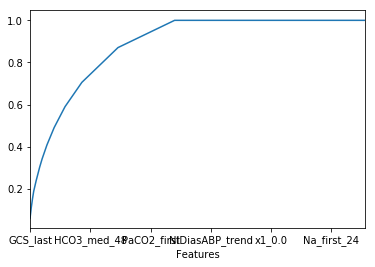

In [139]:
# Get dropped coefficients:
mask_0 = XGB.feature_importances_==0
xgb_drop = list(std_X.columns[mask_0])
print(xgb_drop)

# Get top features (all contributions sum to 1)
xgb_scaled_cumsum = pd.DataFrame({
    'Features': std_X.columns,
    'Scaled_Importance': XGB.feature_importances_/sum(XGB.feature_importances_)
})
xgb_scaled_cumsum = xgb_scaled_cumsum.sort_values(
    'Scaled_Importance',ascending=False).set_index('Features').cumsum()
xgb_scaled_cumsum['Scaled_Importance'].plot()

In [143]:
xgb_scaled_cumsum[:20]

,Scaled_Importance
Features,
GCS_last,0.060606
GCS_trend,0.110193
Glucose_max_48,0.151515
Age,0.187328
GCS_n,0.212121
PaCO2_med,0.236915
x0_2.0,0.258953
Na_trend,0.280992
Urine_last_48,0.303030


In [249]:
pickle.dump(xgb_drop, open('xgb_drop.pickle', 'wb'))

In [140]:
# For simplicity, drop all features with 0 importance, pickle
X_std_drop = std_X.drop(xgb_drop, axis=1)
pickle.dump(X_std_drop, open('X_std_drop.pickle', 'wb'))

# Model Testing

Given the imbalanced nature of the outcome variable, I'll use f1 as my scoring metric.

My overall plan involves 2 general approaches: XGBoost models with the static data, and a hybrid ensemble model that first predicts outcomes based on the sequences of the 3 available variables, and then uses activations from the last layer as additional features in an XGBoost model with the other static features. I'll also try oversampling the minority class to see if that improves the XGBoost model performance.

## XGBoost

### Standard model

I'll use randomized search to try to find optimal hyperparameters.

In [145]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'gamma': [0,.1,1,10],
    'max_depth': [4,5,6,7,8,9],
    'subsample': [1, .8, .6],
    'n_estimators': [10,20,30,50,100]
}

RS = RandomizedSearchCV(XGBClassifier(scale_pos_weight=spw),
                  params,scoring='f1',cv=5, return_train_score=True)

In [146]:
RS.fit(X_std_drop, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=6.2202166064981945,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': [0, 0.1, 1, 10], 'max_depth': [4, 5, 6, 7, 8, 9], 'subsample': [1, 0.8, 0.6], 'n_estimators': [10, 20, 30, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [147]:
RS.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=6.2202166064981945,
       seed=None, silent=True, subsample=0.8)

In [148]:
print(RS.best_score_, '\n\n')
for k in range(10):
    print(
        np.mean([RS.cv_results_['split'+str(i)+'_test_score'][k] 
                 for i in range(5)])
    )

0.4737585757061033 


0.46579346156293555
0.45949288181178016
0.4499036173530958
0.44828562873692357
0.4045929358169976
0.44684244094181286
0.42817725123552053
0.47374092736562845
0.43953723682254936
0.45268268576386184


In [189]:
f1s = []
f1s.append(RS.best_score_)

In [149]:
RS.cv_results_

{'mean_fit_time': array([1.13396397, 0.5921432 , 0.83547397, 0.37730742, 2.64263153,
        0.48934021, 0.38052759, 0.86844544, 0.2771122 , 0.59492116]),
 'std_fit_time': array([0.05254323, 0.03099951, 0.02111967, 0.00843679, 0.22245946,
        0.01841976, 0.05019915, 0.04728128, 0.05563028, 0.04487607]),
 'mean_score_time': array([0.00602698, 0.00502124, 0.00472631, 0.00539036, 0.00974269,
        0.00509419, 0.00372705, 0.00535302, 0.00605259, 0.00443602]),
 'std_score_time': array([0.00087208, 0.00097321, 0.00029946, 0.00142624, 0.00133053,
        0.00148387, 0.00024395, 0.00064419, 0.00171549, 0.00040832]),
 'param_subsample': masked_array(data=[0.8, 0.6, 0.8, 0.8, 1, 0.6, 0.8, 0.8, 1, 0.6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 30, 30, 20, 100, 20, 10, 50, 10, 30],
              mask=[False, False, False, Fals

### Random Oversample

In [155]:
from sklearn.model_selection import StratifiedShuffleSplit
import copy

def resample_kfold(X, y, model, folds=5):
    folds = StratifiedShuffleSplit(test_size=(1/folds))
    folds.get_n_splits(X, y)
    
    history = []
    predictions = [] # (True, Probs, Class)
    for train_index, test_index in folds.split(X, y):
        xtrain, xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        
        # Resample
        # Separate death/survive
        death_inds = np.arange(xtrain.shape[0])[ytrain==1]
        survive_inds = np.arange(xtrain.shape[0])[ytrain==0]
        # Oversample death inds
        oversample_inds = np.random.choice(death_inds,
                                          size=len(survive_inds))
        all_inds = np.concatenate([survive_inds,
                                  oversample_inds])
        np.random.shuffle(all_inds)
        os_x = np.array([xtrain[i] for i in all_inds])
        os_y = np.array([ytrain[i] for i in all_inds])
        
        # Run the model
        loop_model = copy.copy(model)
        loop_model.fit(os_x, os_y)
        
        # Save models
        history.append(loop_model)
        # Save Predictions
        predictions.append((ytest, loop_model.predict_proba(xtest),
                          loop_model.predict(xtest)))
    return {'history':history,
           'predictions':predictions}

In [156]:
# Use settings from best fit
RS.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=6.2202166064981945,
       seed=None, silent=True, subsample=0.8)

In [157]:
xgb_oversample_hist = resample_kfold(X_std_drop.to_numpy(), y.to_numpy(), 
                                     XGBClassifier(gamma=1, 
                                                   max_depth=5, 
                                           n_estimators=50))

In [158]:
np.mean([f1_score(i[0], i[2]) for i in xgb_oversample_hist['predictions']])

0.4784112111314519

In [190]:
f1s.append(np.mean([f1_score(i[0], i[2]) for i in xgb_oversample_hist['predictions']]))

### SMOTE oversample

In [161]:
from imblearn.over_sampling import BorderlineSMOTE

def smote_kfold(X, y, model, folds=5):
    folds = StratifiedShuffleSplit(test_size=(1/folds))
    folds.get_n_splits(X, y)
    
    history = []
    predictions = [] # (True, Probs, Class)
    for train_index, test_index in folds.split(X, y):
        xtrain, xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        
        # BorderlineSMOTE
        X_resampled, y_resampled = BorderlineSMOTE().fit_resample(xtrain, 
                                                                  ytrain)
        
        # Run the model
        loop_model = copy.copy(model)
        loop_model.fit(X_resampled, y_resampled)
        
        # Save models
        history.append(loop_model)
        # Save Predictions
        predictions.append((ytest, loop_model.predict_proba(xtest),
                          loop_model.predict(xtest)))
    return {'history':history,
           'predictions':predictions}

In [162]:
xgb_smote_hist = smote_kfold(X_std_drop.to_numpy(), y, 
                             XGBClassifier(gamma=1, max_depth=5, 
                                           n_estimators=50))

In [163]:
np.mean([f1_score(i[0], i[2]) for i in xgb_smote_hist['predictions']])

0.4191996972489166

In [191]:
f1s.append(np.mean([f1_score(i[0], i[2]) for i in xgb_smote_hist['predictions']]))

## Hybrid Ensemble

### LSTM Component

In [165]:
# Read in seqs, normalize, and make sequence array
raw_df = pd.read_csv('seta_data.csv')
# seq_df = MakeSeq(seq_vars).fit_transform(raw_df)
# pickle.dump(seq_df, open('seq_df.pickle', 'wb'))
seq_df = pickle.load(open('seq_df.pickle', 'rb'))

In [166]:
seq_indicies = [list(seq_df.loc[seq_df.PATIENT_ID==i,'PATIENT_ID'].index)
                for i in seq_df.PATIENT_ID.unique()]

In [167]:
# Standardize
ss_seq = StandardScaler()
seq_df_ss = ss_seq.fit_transform(seq_df)
seqs_ss = np.array([seq_df_ss[i,2:] for i in seq_indicies])

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [174]:
# Get y (not all obs have sequences)
pid_mask = [True if i in seq_df.PATIENT_ID.unique() 
            else False for i in raw_df.PATIENT_ID.unique()]
all_ids = raw_df.PATIENT_ID.unique()
lstm_ids = seq_df.PATIENT_ID.unique()
seq_y = y[pid_mask].to_numpy()

In [175]:
import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM

In [176]:
lstm_0 = Sequential()
lstm_0.add(LSTM(16, input_shape=seqs_ss.shape[1:]))
lstm_0.add(Dropout(.5))
lstm_0.add(Dense(16, activation='relu'))
lstm_0.add(Dropout(.5))
lstm_0.add(Dense(2,activation='softmax'))

In [177]:
# Manual k-fold with random oversampling
def lstm_resample_kfold(X, y, model, n_folds=5):
    folds = StratifiedShuffleSplit(test_size=1/n_folds)
    folds.get_n_splits(X, y)
    
    l_n = 0
    history = []
    predictions = [] # (True, Probs, Class)
    for train_index, test_index in folds.split(np.zeros(len(y)), y):
        xtrain, xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        
        # Resample
        # Separate death/survive
        death_inds = np.arange(xtrain.shape[0])[ytrain==1]
        survive_inds = np.arange(xtrain.shape[0])[ytrain==0]
        # Oversample death inds
        oversample_inds = np.random.choice(death_inds,
                                          size=len(survive_inds))
        all_inds = np.concatenate([survive_inds,
                                  oversample_inds])
        np.random.shuffle(all_inds)
        os_x = np.array([xtrain[i] for i in all_inds])
        os_y = np.array([ytrain[i] for i in all_inds])
        
        # Run the model
        loop_model = keras.models.clone_model(model)
        loop_model.compile(loss='binary_crossentropy', 
                           optimizer='adam',
                           metrics=['accuracy'])
        loop_history = loop_model.fit(os_x, 
                                      keras.utils.to_categorical(os_y),
                                      epochs=20,
                                      batch_size=128)
        
        # Save models
        history.append(loop_history)
        # Save Predictions
        predictions.append((ytest, loop_model.predict(xtest),
                          loop_model.predict_classes(xtest)))
        print('\n\n\n',
              'finished: ', 
              l_n, 
              '\n\n\n')
        l_n = l_n + 1
    return {'history':history,
           'predictions':predictions}

In [178]:
lstm_hist = lstm_resample_kfold(seqs_ss, seq_y,
                                lstm_0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
5422/5422 [==============================] - 1s 254us/step - loss: 0.7028 - acc: 0.5139
Epoch 2/20
5422/5422 [==============================] - 0s 85us/step - loss: 0.6816 - acc: 0.5647
Epoch 3/20
5422/5422 [==============================] - 0s 82us/step - loss: 0.6652 - acc: 0.5900
Epoch 4/20
5422/5422 [==============================] - 0s 81us/step - loss: 0.6573 - acc: 0.6081
Epoch 5/20
5422/5422 [==============================] - 0s 79us/step - loss: 0.6426 - acc: 0.6381
Epoch 6/20
5422/5422 [==============================] - 0s 86us/step - loss: 0.6392 - acc: 0.6389
Epoch 7/20
5422/5422 [==============================] - 0s 83us/step - loss: 0.6328 - acc: 0.6525
Epoch 8/20
5422/5422 [==============================] - 0s 81us/step - loss: 0.6277 - acc: 0.6627
Epoch 9/20
5422/5422 [==============================] - 0s 82us/step - loss: 0.6274 - acc: 0.6612
Epoch 10/20
5422/5422 [==============================] - 0s 89us/step

5422/5422 [==============================] - 0s 77us/step - loss: 0.6737 - acc: 0.5740
Epoch 3/20
5422/5422 [==============================] - 0s 75us/step - loss: 0.6568 - acc: 0.6239
Epoch 4/20
5422/5422 [==============================] - 0s 82us/step - loss: 0.6373 - acc: 0.6503
Epoch 5/20
5422/5422 [==============================] - 0s 83us/step - loss: 0.6266 - acc: 0.6654
Epoch 6/20
5422/5422 [==============================] - 0s 77us/step - loss: 0.6254 - acc: 0.6678
Epoch 7/20
5422/5422 [==============================] - 0s 78us/step - loss: 0.6198 - acc: 0.6772
Epoch 8/20
5422/5422 [==============================] - 0s 71us/step - loss: 0.6167 - acc: 0.6706
Epoch 9/20
5422/5422 [==============================] - 0s 78us/step - loss: 0.6143 - acc: 0.6789
Epoch 10/20
5422/5422 [==============================] - 0s 81us/step - loss: 0.6062 - acc: 0.6813
Epoch 11/20
5422/5422 [==============================] - 0s 77us/step - loss: 0.6061 - acc: 0.6831
Epoch 12/20
5422/5422 [======

In [179]:
np.mean([f1_score(i[0], i[2]) for i in lstm_hist['predictions']])

0.39372655686773383

In [192]:
f1s.append(np.mean([f1_score(i[0], i[2]) for i in lstm_hist['predictions']]))

In [180]:
for loop in lstm_hist['predictions']:
    print(classification_report(loop[0], loop[2]))

              precision    recall  f1-score   support

           0       0.93      0.69      0.80       678
           1       0.27      0.69      0.39       110

   micro avg       0.69      0.69      0.69       788
   macro avg       0.60      0.69      0.59       788
weighted avg       0.84      0.69      0.74       788

              precision    recall  f1-score   support

           0       0.95      0.67      0.79       678
           1       0.27      0.76      0.40       110

   micro avg       0.69      0.69      0.69       788
   macro avg       0.61      0.72      0.60       788
weighted avg       0.85      0.69      0.73       788

              precision    recall  f1-score   support

           0       0.94      0.64      0.76       678
           1       0.25      0.73      0.37       110

   micro avg       0.65      0.65      0.65       788
   macro avg       0.59      0.68      0.56       788
weighted avg       0.84      0.65      0.70       788

              preci

### Ensemble

In [183]:
def full_to_seq_id(seq_ids, full_ids):
    '''Maps missing seq_ids to full_id indices (not labels).
    Returns id_mask, full_seq_dict'''
    id_mask = [True if i in seq_ids else False for i in full_ids]
    full_id = np.arange(len(id_mask))[id_mask]
    seq_id = np.arange(sum(id_mask))
    full_seq_dict = dict(zip(full_id, seq_id))
    return np.array(id_mask), full_seq_dict

# Low let's try combining xgb_model (no resample) + oversample lstm
def hybrid(lstm_X, lstm_y, lstm_ids, seq_ids,
           xgb_X, xgb_y,
           lstm_model, xgb_model, n_folds=5):
    # get mask and dict for merging missing values
    id_mask, id_dict = full_to_seq_id(lstm_ids, seq_ids)

    folds = StratifiedShuffleSplit(test_size=1/n_folds)
    folds.get_n_splits(xgb_X, xgb_y) # xgb_X has all obs
    
    l_n = 0
    history = []
    predictions = [] # (True, Probs, Class)
    for train_index, test_index in folds.split(np.zeros(len(y)), xgb_y):
        # Get the mask for seq obs
        train_mask, test_mask = id_mask[train_index], id_mask[test_index]
        
        # Get xgb (full) train/test
        xgb_xtr, xgb_xte = xgb_X[train_index], xgb_X[test_index]
        xgb_ytr, xgb_yte = xgb_y[train_index], xgb_y[test_index]
        
        # Get lstm train/test
        l_train_i = [id_dict[i] for i in train_index if i in id_dict.keys()]
        l_test_i = [id_dict[i] for i in test_index  if i in id_dict.keys()]
        lstm_xtr, lstm_xte = lstm_X[l_train_i], lstm_X[l_test_i]
        lstm_ytr, lstm_yte = lstm_y[l_train_i], lstm_y[l_test_i]
        
        # Resample
        # Separate death/survive
        death_inds = np.arange(lstm_xtr.shape[0])[lstm_ytr==1]
        survive_inds = np.arange(lstm_xtr.shape[0])[lstm_ytr==0]
        # Oversample death inds
        oversample_inds = np.random.choice(death_inds,
                                          size=len(survive_inds))
        all_inds = np.concatenate([survive_inds,
                                  oversample_inds])
        np.random.shuffle(all_inds)
        os_x = np.array([lstm_xtr[i] for i in all_inds])
        os_y = np.array([lstm_ytr[i] for i in all_inds])
        
        # Train the model
        loop_model = keras.models.clone_model(lstm_model)
        loop_model.compile(loss='binary_crossentropy', 
                           optimizer='adam',
                           metrics=['accuracy'])
        lstm_history = loop_model.fit(os_x, 
                                      keras.utils.to_categorical(os_y),
                                      epochs=20,
                                      batch_size=128)
        
        # Save the model weights, compile
        act_m = Sequential()
        act_m.add(LSTM(16, input_shape=seqs_ss.shape[1:],
                       weights=loop_model.layers[0].get_weights()))
        act_m.add(Dense(16, activation='relu',
                        weights=loop_model.layers[2].get_weights()))
        
        # Get activations of last layer for original training
        preds = act_m.predict(lstm_xtr)
        pred_merge = np.empty((xgb_xtr.shape[0],16))
        pred_merge[:] = np.nan
        pred_merge[train_mask,:] = preds
        col_mean = np.nanmean(pred_merge, axis=0)
        inds = np.where(np.isnan(pred_merge))
        pred_merge[inds] = np.take(col_mean, inds[1])
        merge_X = np.concatenate([xgb_xtr, pred_merge], axis=1)
        
        # Train XGB on merge_x
        loop_xgb = copy.copy(xgb_model)
        loop_xgb.fit(merge_X, xgb_ytr)
        
        # Get test predictions (first lstm, then append preds to get xgb)
        lstm_test_preds = act_m.predict(lstm_xte)
        lstm_test_merge = np.empty((xgb_xte.shape[0],16))
        lstm_test_merge[:] = np.nan
        lstm_test_merge[test_mask,:] = lstm_test_preds
        col_mean = np.nanmean(lstm_test_merge, axis=0)
        inds = np.where(np.isnan(lstm_test_merge))
        lstm_test_merge[inds] = np.take(col_mean, inds[1])
        merge_X = np.concatenate([xgb_xte, lstm_test_merge], axis=1)
        
        # Save Predictions
        predictions.append((xgb_yte, loop_xgb.predict_proba(merge_X),
                          loop_xgb.predict(merge_X)))
        
        # Save models
        history.append((lstm_history, loop_xgb))
        
        print('\n\n\n',
              'finished: ', 
              l_n, 
              '\n\n\n')
        l_n = l_n + 1
    return {'history':history,
           'predictions':predictions}

In [184]:
hybrid_hist = hybrid(seqs_ss, seq_y,
                     lstm_ids=lstm_ids, seq_ids=all_ids, 
                     xgb_X=X_std_drop.to_numpy(), xgb_y=y,
                     lstm_model=lstm_0, 
                     xgb_model= XGBClassifier(gamma=1, max_depth=5, 
                                           n_estimators=50,
                                             scale_pos_weight=spw),
                    n_folds=5)

Epoch 1/20
5420/5420 [==============================] - 3s 465us/step - loss: 0.6882 - acc: 0.5487
Epoch 2/20
5420/5420 [==============================] - 0s 83us/step - loss: 0.6691 - acc: 0.5930
Epoch 3/20
5420/5420 [==============================] - 0s 84us/step - loss: 0.6558 - acc: 0.6221
Epoch 4/20
5420/5420 [==============================] - 0s 77us/step - loss: 0.6434 - acc: 0.6354
Epoch 5/20
5420/5420 [==============================] - 0s 79us/step - loss: 0.6375 - acc: 0.6452
Epoch 6/20
5420/5420 [==============================] - 0s 91us/step - loss: 0.6284 - acc: 0.6603
Epoch 7/20
5420/5420 [==============================] - 0s 90us/step - loss: 0.6229 - acc: 0.6747
Epoch 8/20
5420/5420 [==============================] - 0s 91us/step - loss: 0.6172 - acc: 0.6819
Epoch 9/20
5420/5420 [==============================] - 1s 99us/step - loss: 0.6168 - acc: 0.6808
Epoch 10/20
5420/5420 [==============================] - 0s 88us/step - loss: 0.6119 - acc: 0.6843
Epoch 11/20
5420/5

5416/5416 [==============================] - 1s 97us/step - loss: 0.6673 - acc: 0.5881
Epoch 4/20
5416/5416 [==============================] - 1s 96us/step - loss: 0.6494 - acc: 0.6172
Epoch 5/20
5416/5416 [==============================] - 0s 76us/step - loss: 0.6354 - acc: 0.6344
Epoch 6/20
5416/5416 [==============================] - 0s 89us/step - loss: 0.6236 - acc: 0.6551
Epoch 7/20
5416/5416 [==============================] - 0s 84us/step - loss: 0.6250 - acc: 0.6601
Epoch 8/20
5416/5416 [==============================] - 0s 87us/step - loss: 0.6121 - acc: 0.6763
Epoch 9/20
5416/5416 [==============================] - 0s 80us/step - loss: 0.6068 - acc: 0.6797
Epoch 10/20
5416/5416 [==============================] - 0s 88us/step - loss: 0.6052 - acc: 0.6846
Epoch 11/20
5416/5416 [==============================] - 0s 92us/step - loss: 0.5982 - acc: 0.6889
Epoch 12/20
5416/5416 [==============================] - 0s 91us/step - loss: 0.5937 - acc: 0.7011
Epoch 13/20
5416/5416 [=====

In [193]:
f1s.append(np.mean([f1_score(i[0], i[2]) for i in hybrid_hist['predictions']]))

In [185]:
print(np.mean([f1_score(i[0], i[2]) for i in hybrid_hist['predictions']]),
     '\n\n\n')
for loop in hybrid_hist['predictions']:
    print(classification_report(loop[0], loop[2]))

0.44802692549796863 



              precision    recall  f1-score   support

           0       0.92      0.83      0.87       689
           1       0.33      0.52      0.41       111

   micro avg       0.79      0.79      0.79       800
   macro avg       0.62      0.68      0.64       800
weighted avg       0.83      0.79      0.81       800

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       689
           1       0.39      0.62      0.48       111

   micro avg       0.81      0.81      0.81       800
   macro avg       0.66      0.73      0.68       800
weighted avg       0.86      0.81      0.83       800

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       689
           1       0.39      0.59      0.47       111

   micro avg       0.81      0.81      0.81       800
   macro avg       0.66      0.72      0.68       800
weighted avg       0.85      0.81      0.83       

In [186]:
save_models = {'xgb_0': RS,
              'xgb_resample': xgb_oversample_hist,
              'xgb_smote': xgb_smote_hist,
              'lstm_hist': lstm_hist,
              'hybrid': hybrid_hist}

In [187]:
pickle.dump(save_models, open('save_models.pickle', 'wb'))

# Final Model Evaluation

In [188]:
save_models = pickle.load(open('save_models.pickle', 'rb'))

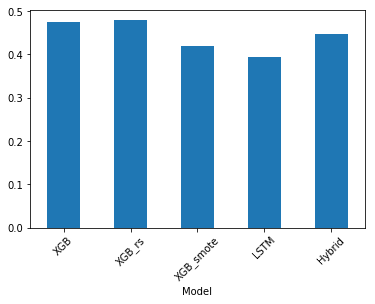

In [202]:
# f1 comparison
pd.DataFrame({
    'Model': ['XGB', 'XGB_rs', 'XGB_smote', 'LSTM', 'Hybrid'],
    'F1': f1s
}).plot.bar(x='Model', y='F1', rot=45, legend=False)


In [232]:
# Precision/Recal Curve of XGB_rs
xgb_rs_labels = [i for j in 
                 [i[0] for i in xgb_oversample_hist['predictions']]
                 for i in j]

xgb_rs_probs = [i for j in 
                [i[1] for i in xgb_oversample_hist['predictions']]
                for i in j]

In [233]:
xgb_rs_probs = [i[1] for i in xgb_rs_probs]

Average precision-recall score: 0.49


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.49')

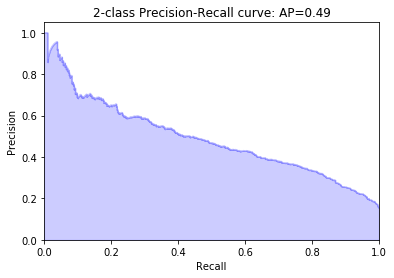

In [230]:
from inspect import signature
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
average_precision = average_precision_score(xgb_rs_labels, xgb_rs_probs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(xgb_rs_labels, xgb_rs_probs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Average precision-recall score: 0.49


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.14')

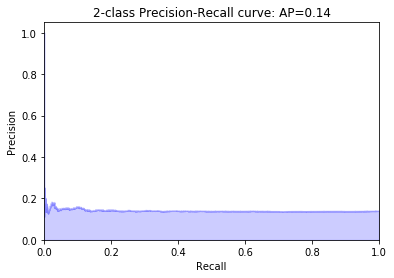

In [234]:
# Random Curve for Comparison
rand_guess = np.random.uniform(size=8000)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


average_precision = average_precision_score(xgb_rs_labels, rand_guess)
precision, recall, _ = precision_recall_curve(xgb_rs_labels, rand_guess)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [256]:
# Run xgb with random oversampling on complete dataset
# Resample
# Separate death/survive
death_inds = np.arange(X_std_drop.shape[0])[y==1]
survive_inds = np.arange(X_std_drop.shape[0])[y==0]
# Oversample death inds
oversample_inds = np.random.choice(death_inds,
                                  size=len(survive_inds))
all_inds = np.concatenate([survive_inds,
                          oversample_inds])
np.random.shuffle(all_inds)
os_x = np.array([X_std_drop.to_numpy()[i] for i in all_inds])
os_y = np.array([y.to_numpy()[i] for i in all_inds])

# # Run the model
final_class = XGBClassifier(gamma=1, max_depth=5, n_estimators=50)
final_class.fit(os_x, os_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [260]:
pickle.dump(final_class, open('final_class.pickle', 'wb'))

In [278]:
final_class.predict(X_std_drop.to_numpy())

array([0, 0, 0, ..., 0, 1, 0])